### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 6
### Due: Saturday, Mar 22nd at 11.59pm CT
---

This problem has to do with density estimation and clustering. 

1. Read in `hw6_data_1.npy`. The dataset should consist of $1000$ samples with $2$ features. Note that the last column are the labels, not another feature. Make a $2$-D scatter plot of the data colored by their labels. 

MEK: Import block

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from astroML.density_estimation import KNeighborsDensity
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn import preprocessing

MEK: Read in data

In [3]:
hw6data1 = np.load("./../../homeworks/hw_data/hw6_data_1.npy")
col1 = hw6data1[:,0]
col2 = hw6data1[:,1]
col3 = hw6data1[:,2]

MEK: Plot data with colors defined by label

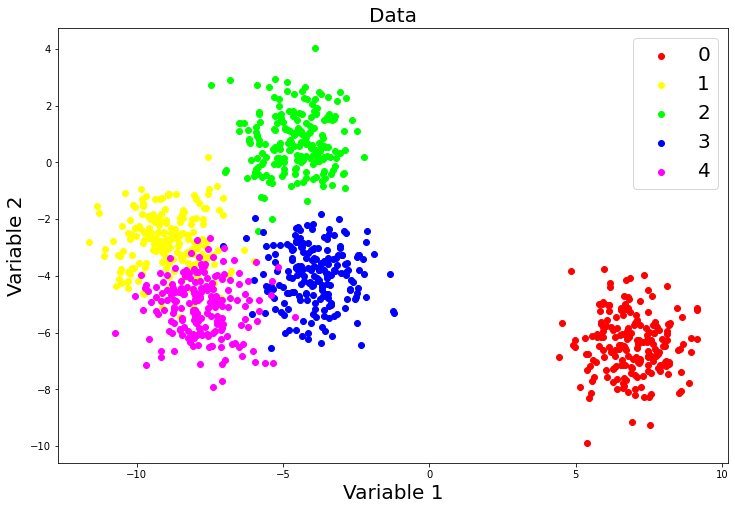

In [4]:
plt.figure(figsize=(12,8))
colors=["red","yellow","lime","blue","magenta"]

for i in range (0,5):
    idx = np.where(col3==i)
    plt.scatter(col1[idx], col2[idx], color=colors[i], label=str(i))

plt.title("Data", fontsize=20)
plt.xlabel("Variable 1", fontsize=20)
plt.ylabel("Variable 2", fontsize=20)
plt.legend(fontsize=20)
plt.show()

2. Start with kernel density estimation on the data set. First, perform a grid search $5$-fold cross-validation to find the best bandwidth, testing $30$ bandwidths between $0.1$ and $1.0$. What is this best bandwidth? Using this best bandwidth, plot the two-dimensional kernel density estimate of the distribution. 

MEK: Perform KDE with many bandwidths, print best bandwidth

In [19]:
data = np.column_stack([col1,col2])
bwrange = np.linspace(0.1, 1., 30) # Test 30 bandwidths from 0.1 to 1.0
K = 5 # Do 5-fold cross validation
grid = GridSearchCV(KernelDensity(), {'bandwidth': bwrange}, cv=K) # Try each bandwidth with K-folds
grid.fit(data) #Fit the histogram data that we started the lecture with.
h_opt = grid.best_params_['bandwidth']
print("Best bandwidth =", "%.4f"%h_opt)

Best bandwidth = 0.4724


MEK: Fit KDE with best bandwidth, plot

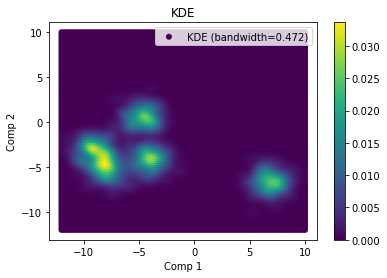

In [6]:
kde = KernelDensity(kernel='gaussian', bandwidth=h_opt)
kde.fit(data) #fit the model to the data

u = v = np.linspace(-12,10,100)
Xgrid = np.vstack(list(map(np.ravel, np.meshgrid(u, v)))).T
dens = np.exp(kde.score_samples(Xgrid)) #evaluate the model on the grid

plt.scatter(Xgrid[:,0], Xgrid[:,1], c=dens, edgecolor="None", label="KDE (bandwidth="+str(round(h_opt,3))+")")
plt.colorbar()
plt.legend()
plt.xlabel("Comp 1")
plt.ylabel("Comp 2")
plt.title("KDE")
plt.show()

SRT: Nice visualization!

3. Now try a nearest neighbors approach to estimating the density. Use the Bayesian nearest neighbors option. Plot the estimated distribution. What value of $k$ neighbors do you need to make the plot look similar to your KDE distribution?

MEK: Perform nearest neighbors with 80 closest neighbors, plot. 80 makes it look similar to KDE plot!

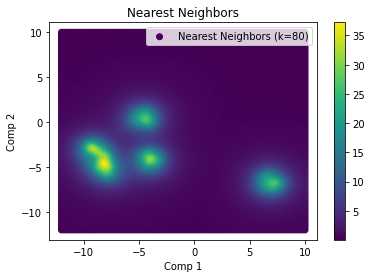

In [7]:
k=80
nbrs = KNeighborsDensity('bayesian', n_neighbors=k)
nbrs.fit(data)
dens_nbrs = nbrs.eval(Xgrid)

plt.scatter(Xgrid[:,0], Xgrid[:,1], c=dens_nbrs, label="Nearest Neighbors (k=%i)" % k)
plt.colorbar()
plt.legend()
plt.xlabel("Comp 1")
plt.ylabel("Comp 2")
plt.title("Nearest Neighbors")
plt.show()

SRT: Nice!

4. Now fit a Gaussian mixture model. Compute the AIC and BIC for the number of GMM components between $1$ and $10$. Plot these AIC and BIC values as a function of number of components. What is the optimal number according to the BIC? Fit the data set with this optimal number of GMM components, and create a new plot that shows the data set, the GMM component mean locations, and the $2$-sigma GMM component ellipses. *(Use the code below to help with plotting the ellipses.)*

MEK: Grab AIC and BIC, plot both against each other

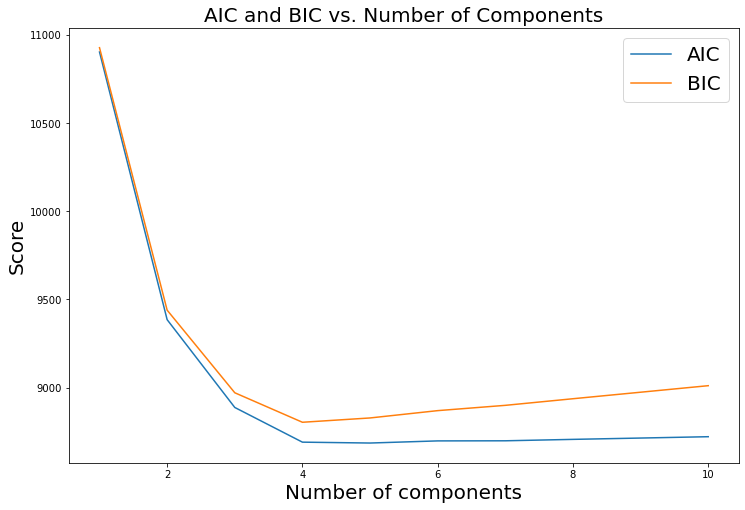

In [8]:
AIC = []
BIC = []
num_comp = np.arange(1,11)

for ii in num_comp:
    gmm = GaussianMixture(ii) #three components
    gmm.fit(data)
    log_dens = gmm.score(data)
    AIC.append(gmm.aic(data))
    BIC.append(gmm.bic(data))

plt.figure(figsize=(12,8))
plt.plot(num_comp, AIC, label="AIC")
plt.plot(num_comp, BIC, label="BIC")
plt.title("AIC and BIC vs. Number of Components", fontsize=20)
plt.xlabel("Number of components", fontsize=20)
plt.ylabel("Score", fontsize=20)
plt.legend(fontsize=20)
plt.show()

MEK: Find the number of components that minimizes the BIC

In [9]:
bic_opt = num_comp[np.where(BIC==np.min(BIC))][0]
print("Optimal BIC =", bic_opt)

Optimal BIC = 4


MEK: Borrow SRT function

In [10]:
from matplotlib.patches import Ellipse

def draw_ellipse(mu, C, scales=[1, 2, 3], ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()

    # find principal components and rotation angle of ellipse
    sigma_x2 = C[0, 0]
    sigma_y2 = C[1, 1]
    sigma_xy = C[0, 1]

    alpha = 0.5 * np.arctan2(2 * sigma_xy,
                          (sigma_x2 - sigma_y2))
    tmp1 = 0.5 * (sigma_x2 + sigma_y2)
    tmp2 = np.sqrt(0.25 * (sigma_x2 - sigma_y2) ** 2 + sigma_xy ** 2)

    sigma1 = np.sqrt(tmp1 + tmp2)
    sigma2 = np.sqrt(tmp1 - tmp2)

    for scale in scales:
        ax.add_patch(Ellipse(xy=(mu[0], mu[1]),
                          width=2 * scale * sigma1, height=2 * scale * sigma2,
                          angle=alpha * 180. / np.pi, alpha=0.5,color="cornflowerblue",
                          **kwargs))

MEK: Perform Gaussian mixture model with number of components that minimizes BIC, plot!

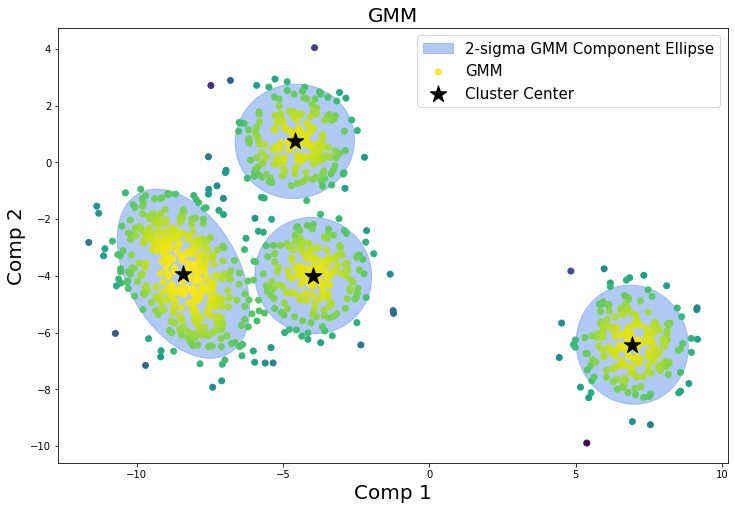

In [11]:
gmm = GaussianMixture(bic_opt)
gmm.fit(data)
score = gmm.score_samples(data)
means = gmm.means_
covs = gmm.covariances_

plt.figure(figsize=(12,8))
cov = np.cov(data.T)
i=0
for mean, cov in zip(means, covs):
    if i==0:
        draw_ellipse(mean, cov, scales=[2], label="2-sigma GMM Component Ellipse")
    else:
        draw_ellipse(mean, cov, scales=[2])
    i += 1
    
plt.scatter(col1, col2, c=score, label="GMM")
plt.scatter(means[:,0], means[:,1], s=300, color="black", marker="*", label="Cluster Center")
plt.title("GMM", fontsize=20)
plt.xlabel("Comp 1", fontsize=20)
plt.ylabel("Comp 2", fontsize=20)
plt.legend(fontsize=15)
plt.show()

SRT: Awesome.

5. Now try Kmeans clustering with $5$ clusters. 
    - Use the `StandardScalar` to scale the data.
    - Fit the Kmeans model.
    - Find the cluster centers, and then inverse transform these cluster centers back to the original unscaled coordinates.
    - Predict the labels for the scaled data.
    - Finally, make a two-panel side by side plot showing (a) the original data colored by its labels, then (b) the data colored by the Kmeans predicted labels, with cluster centers superposed.

In [ ]:
MEK: Perform Kmeans with 5 clusters, make two plots where one plot is the true data and one is the data sorted by the way I fit it with the Km

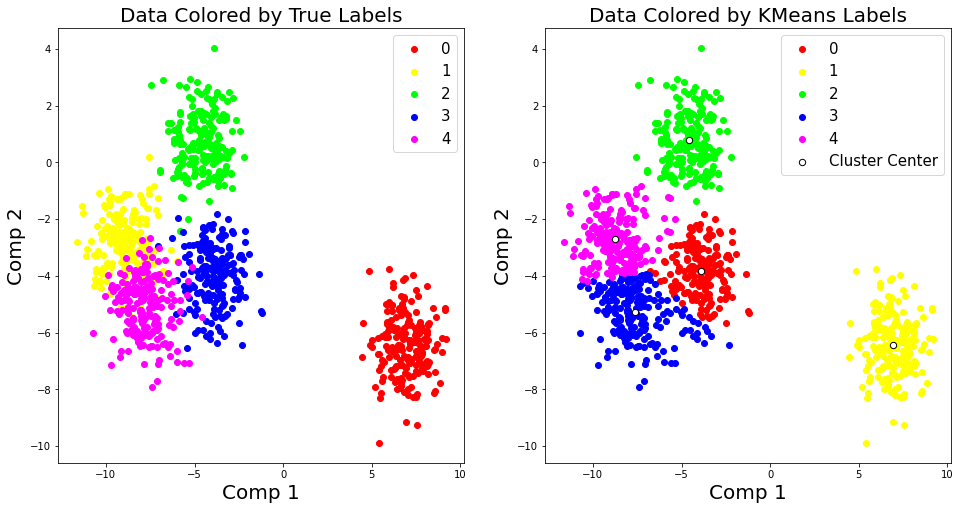

In [12]:
n_clusters = 5
scaler = preprocessing.StandardScaler()
clf = KMeans(n_clusters)
clf.fit(scaler.fit_transform(data))
preds = clf.predict(scaler.fit_transform(data))
cluster_centers = scaler.inverse_transform(clf.cluster_centers_)

# Make some plots
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,8))

for i in range (0,5):
    idx = np.where(col3==i)
    ax1.scatter(col1[idx], col2[idx], color=colors[i], label=str(i))

for i in range (0,5):
    idx = np.where(preds==i)
    ax2.scatter(col1[idx], col2[idx], color=colors[i], label=str(i))

ax2.scatter(cluster_centers[:, 0], cluster_centers[:, 1],
           s=40, c='w', edgecolors='k',label="Cluster Center")

ax1.legend(fontsize=15)
ax2.legend(fontsize=15)
ax1.set_title("Data Colored by True Labels", fontsize=20)
ax1.set_xlabel("Comp 1", fontsize=20)
ax1.set_ylabel("Comp 2", fontsize=20)
ax2.set_title("Data Colored by KMeans Labels", fontsize=20)
ax2.set_xlabel("Comp 1", fontsize=20)
ax2.set_ylabel("Comp 2", fontsize=20)
plt.show()

SRT: Perfect, Mary.

50/50